# Case 1: Earthquake Determination

An earthquake arrival time data of its P and S wave was recorded by a 4-stations network as shown below.

| Station | Easting | Northing | Elevation | P-wave  | S-wave   |
|:-------:|:-------:|:--------:|:---------:|:-------:|:--------:|
|  ST01   |  788000 |  9207000 |     0     | 17.2691 |  18.7024 |
|  ST02   |  788000 |  9211000 |     0     | 16.7343 |  17.7771 |
|  ST03   |  791000 |  9207500 |     0     | 16.9029 |  18.0688 |
|  ST04   |  792500 |  9211000 |     0     | 16.9029 |  18.0688 |


The earth structure beneath the network is assumed to follow this velocity layering model.

| Layer   | Top Boundary | Vp   |
|---------|:------------:|------|
| Layer 1 |      0       | 2100 |
| Layer 2 |    -2900     | 3300 |
| Layer 3 |    -3600     | 3700 |
| Layer 4 |    -4200     | 4200 |
| Layer 5 |    -4600     | 4500 |
| Layer 6 |    -5700     | 6000 |
| Layer 7 |   -16000     | 7000 |


Determine the hypocenter of the earthquake using Geiger Method.

<hr style="border: 2px solid;">
1. &emsp; $ \mbox{Preparation} $

&emsp;&emsp; a.) &emsp; Importing library needed for the code

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

<hr>
&emsp;&emsp; b.) &emsp; Plugging in the raw data

In [2]:
# Data from stations
Data = np.array([
    [788000, 9207000, 0, 17.2691, 18.7024],
    [788000, 9211000, 0, 16.7343, 17.7771],
    [791000, 9207500, 0, 16.9029, 18.0688],
    [792500, 9211000, 0, 16.9029, 18.0688]
])

In [3]:
# Data from velocity model
Vmod = np.array([
    [     0,   2100],
    [ -2900,   3300],
    [ -3600,   3700],
    [ -4200,   4200],
    [ -4600,   4500],
    [ -5700,   6000],
    [-16000,   7000]
])

<hr>
&emsp;&emsp; c.) &emsp; Assigning data

In [4]:
# Assigning station coordinates
Stat = Data[:,0:3]

In [5]:
# Assigning tp ts data
tp = Data[:,3]
ts = Data[:,4]

<hr style="border: 2px solid;">
2. &emsp; $ \mbox{Defining Functions} $

&emsp;&emsp; a.) &emsp; Defining wadati functions to calculate origin time based on tp and ts

In [6]:
def wadati(tp, ts):
    s = len(tp)  # number of stations

    # Building matrices
    X = np.vstack((tp, np.ones(s))).T  # Transposed for correct shape
    Y = (ts - tp).reshape(-1, 1)  # Reshape to make it a column vector

    # Inversion step
    M = np.linalg.inv(X.T @ X) @ X.T @ Y
    # Calculate origin time
    to = -M[1] / M[0]

    return to.item()  # Return as a standard Python float

<hr>
&emsp;&emsp; b.) &emsp; Defining traveltime function to calculate the travel time of the P-wave

In [7]:
def traveltime(Hypo, Stat, Vmod):
    l = len(Vmod)
    z = Vmod[:, 0]
    v = Vmod[:, 1]

    # -1- FINDING NUMBER OF LAYER
    for j in range(l - 1):
        if Hypo[2] <= Vmod[j, 0] and Hypo[2] > Vmod[j+1, 0]:
            nLay = j

    # -2- CALCULATING EPICENTRAL DISTANCE
    D = np.sqrt((Stat[0] - Hypo[0])**2 + (Stat[1] - Hypo[1])**2)
    h = np.zeros(nLay+1)
    t = np.zeros(nLay+1)
    d = np.zeros(nLay+1)

    # -3- CALCULATING TCAL AND DT
    a = 0
    b = 90
    for ite in range(150):
        theta = (b + a) / 2  # bisection
        p = np.sin(np.radians(theta)) / v[nLay]
        for i in range(nLay - 1):
            h[i] = z[i] - z[i + 1]
            t[i] = h[i] / (v[i] * np.sqrt(1 - p**2 * v[i]**2))
            d[i] = h[i] * v[i] * p / np.sqrt(1 - p**2 * v[i]**2)
        h[nLay] = z[nLay] - Hypo[2]
        t[nLay] = h[nLay] / (v[nLay] * np.sqrt(1 - p**2 * v[nLay]**2))
        d[nLay] = h[nLay] * v[nLay] * p / np.sqrt(1 - p**2 * v[nLay]**2)
        delta = np.sum(d)
        tcal = np.sum(t)

        if delta <= D:
            a = theta
        elif delta >= D:
            b = theta

    dt = np.zeros(4)
    dt[0] = p * (Hypo[0] - Stat[0]) / delta
    dt[1] = p * (Hypo[1] - Stat[1]) / delta
    dt[2] = -np.sqrt(1 - p**2 * v[nLay]**2) / v[nLay]
    dt[3] = 1

    return tcal, dt

<hr>
&emsp;&emsp; c.) &emsp; Defining functions for Naive Gauss Elimination

In [8]:
def ng_elimination(A,b):

    # generating augmented matrix
    aug = np.hstack((A,b))
    
    # forward elimination
    n = len(b)
    for i in range(n):
        for j in range(i+1,n):
            scale = aug[j,i]/aug[i,i]
            aug[j] = aug[j] - scale*aug[i]

    # backward substitution
    m = np.zeros(n)
    for i in range(n-1, -1, -1):
        m[i] = (aug[i,n] - np.dot(aug[i,i:n], m[i:n])) / aug[i,i]

    return m

<hr style="border: 2px solid;">
3. &emsp; $ \mbox{Pre-processing} $

&emsp;&emsp; Determine the origin time and the nearest station for the initial hypocenter parameter

In [9]:
# calculate origin time
oritime = wadati(tp,ts)
# calculate travel time to each stations
tobs = tp - oritime
tobs = tobs.reshape(1,4)
tobs = tobs.T
# finding the nearest station to the event
ID = np.argmin(tobs)
# initial hypocenter parameter
Hypo = np.zeros(4)
Hypo[0] = Stat[ID,0]+100
Hypo[1] = Stat[ID,1]+100
Hypo[2] = Stat[ID,2]-800
Hypo[3] = oritime

<hr style="border: 2px solid;">
4. &emsp; $ \mbox{Processing} $

&emsp;&emsp; a.) &emsp; Setting up number of iteration and processing log

In [10]:
# allocate for processing log
N = 10 # iteration times
LOG = np.zeros((N+1,9))
LOG[0,5:] = Hypo

<hr>
&emsp;&emsp; b.) &emsp; Execute processing loop

In [11]:
for ite in range(N): # iterates N times
    
    # calculate tcal and dt
    tcal = np.zeros((4,1))
    dt = np.zeros((4, 4))
    
    for j in range(4):
        tcal[j], dt[j, :] = traveltime(Hypo, Stat[j, :], Vmod)
    
    # generating matrix A and b
    r = tcal - tobs
    G = dt

    # calculating residual value
    res = np.dot(r.T,r)
    res = res[0][0]
    
    # solving matrix m for correcting hypocenter parameters
    m = ng_elimination(G,r)
    
    # updating hypocenter parameters
    Hypo = Hypo - m
    if Hypo[2] >= 0:
        Hypo[2] = -800
    
    # storing log processing data
    LOG[ite+1,0] = res
    LOG[ite+1,1:5] = m
    LOG[ite+1,5:] = Hypo

<hr>
&emsp;&emsp; c.) &emsp; Checking for error convergence

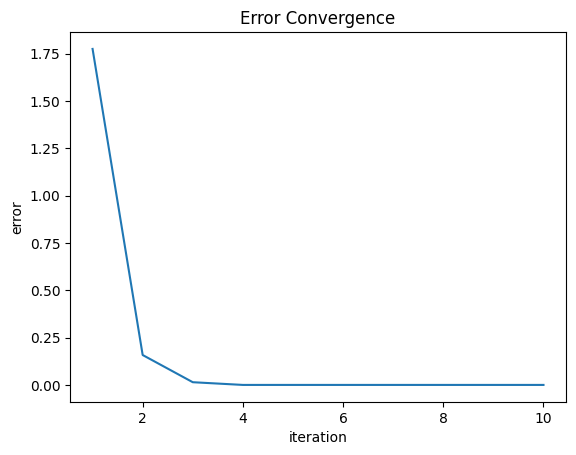

In [12]:
# error values for each iteration
err = LOG[1:,0]
itr = np.arange(1,N+1) 

# Creating the line plot
plt.plot(itr, err)

# Adding labels and title
plt.xlabel('iteration')
plt.ylabel('error')
plt.title('Error Convergence')

# Display the plot
plt.show()

<hr style="border: 2px solid;">
5. &emsp; $ \mbox{Visualization} $

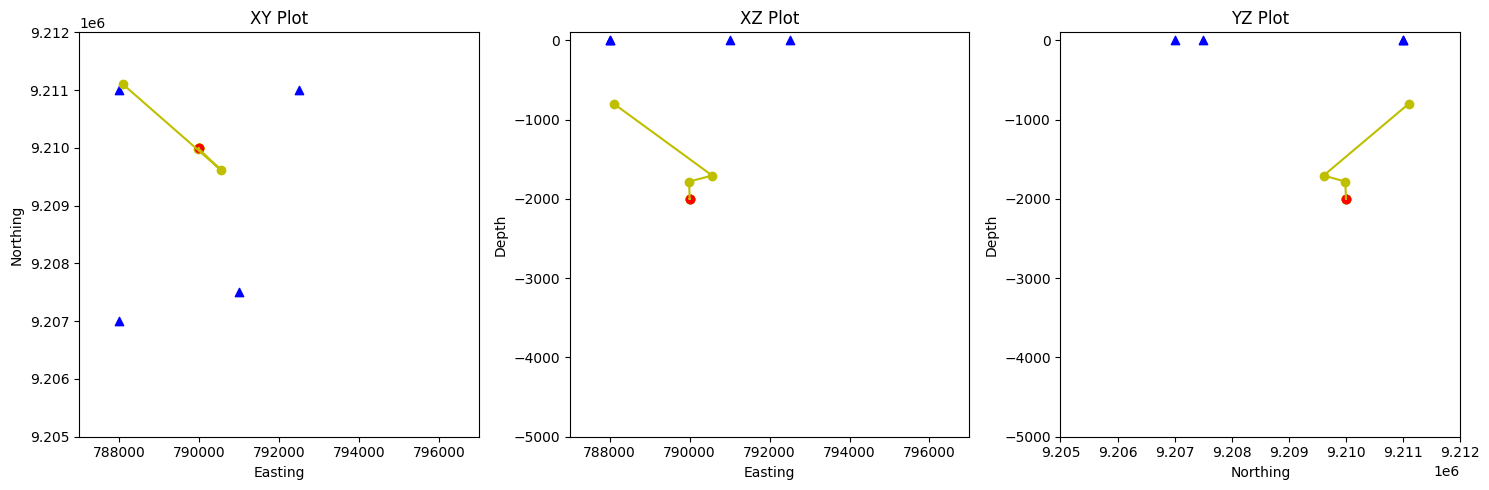

In [13]:
# 2D plotting

Xs, Ys, Zs = Stat[:,0], Stat[:,1], Stat[:,2]
Xh, Yh, Zh = LOG[:,5], LOG[:,6], LOG[:,7]
XH, YH, ZH = Hypo[0], Hypo[1], Hypo[2]

# Creating subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# XY plot
axs[0].scatter(Xs, Ys, color='b', marker='^')
axs[0].scatter(Xh, Yh, color='y')
axs[0].plot(Xh, Yh, color='y')
axs[0].scatter(XH, YH, color='r')
axs[0].set_xlabel('Easting')
axs[0].set_ylabel('Northing')
axs[0].set_title('XY Plot')
axs[0].set_xlim([787000, 797000])  # Set the range for the X-axis
axs[0].set_ylim([9205000, 9212000])  # Set the range for the Y-axis

# XZ plot
axs[1].scatter(Xs, Zs, color='b', marker='^')
axs[1].scatter(Xh, Zh, color='y')
axs[1].plot(Xh, Zh, color='y')
axs[1].scatter(XH, ZH, color='r')
axs[1].set_xlabel('Easting')
axs[1].set_ylabel('Depth')
axs[1].set_title('XZ Plot')
axs[1].set_xlim([787000, 797000])  # Set the range for the X-axis
axs[1].set_ylim([-5000, 100])  # Set the range for the Z-axis

# YZ plot
axs[2].scatter(Ys, Zs, color='b', marker='^')
axs[2].scatter(Yh, Zh, color='y')
axs[2].plot(Yh, Zh, color='y')
axs[2].scatter(YH, ZH, color='r')
axs[2].set_xlabel('Northing')
axs[2].set_ylabel('Depth')
axs[2].set_title('YZ Plot')
axs[2].set_xlim([9205000, 9212000])  # Set the range for the Y-axis
axs[2].set_ylim([-5000, 100])  # Set the range for the Z-axis

# Display the plot
plt.tight_layout()
plt.show()


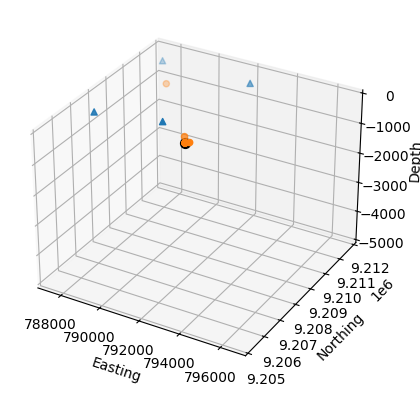

In [14]:
# 3D plotting stations

# Create a figure
fig = plt.figure()

# Add a 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(Xs, Ys, Zs, marker='^')
ax.scatter(Xh, Yh, Zh)
ax.scatter(XH, YH, ZH, color='k', s=50)

# Setting the axes limits
ax.set_xlim([787000, 797000])  # Set the range for the X-axis
ax.set_ylim([9205000, 9212000])  # Set the range for the Y-axis
ax.set_zlim([-5000, 0])  # Set the range for the Z-axis

# Adding labels
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
ax.set_zlabel('Depth')

# Show the plot
plt.show()